<a href="https://colab.research.google.com/github/snesne28/Animal-ReID-Updates/blob/main/res50_feature_ext_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Step 1: Configuration and GPU Check ###

✅ GPU (Tesla T4) is available and will be used.
Mounted at /content/drive
Google Drive mounted successfully.

### Step 2: (Optional) Automatically Split the Dataset ###
Creating directory structure at '/content/drive/MyDrive/split_animal_dataset'...

Processing class: Cheetah Dataset

Processing class: Leopard Dataset

Processing class: Tiger Dataset

Data splitting complete!

### Step 3: Create Data Loaders ###
Found classes: ['Cheetah Dataset', 'Leopard Dataset', 'Tiger Dataset']
Dataset sizes: {'train': 4106, 'val': 513, 'test': 514}

### Step 4: Build the Model ###
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 175MB/s]


Model architecture created successfully.
Sequential(
  (0): Linear(in_features=2048, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=512, out_features=3, bias=True)
)

### Step 5: Train the Model ###
Epoch 1/15
----------
train Loss: 0.4195 Acc: 0.8276
val Loss: 0.2136 Acc: 0.9220
Epoch 2/15
----------
train Loss: 0.3002 Acc: 0.8770
val Loss: 0.1627 Acc: 0.9474
Epoch 3/15
----------
train Loss: 0.2859 Acc: 0.8872
val Loss: 0.1727 Acc: 0.9298
Epoch 4/15
----------
train Loss: 0.2650 Acc: 0.8948
val Loss: 0.1680 Acc: 0.9318
Epoch 5/15
----------
train Loss: 0.2404 Acc: 0.9045
val Loss: 0.1545 Acc: 0.9493
Epoch 6/15
----------
train Loss: 0.2509 Acc: 0.8999
val Loss: 0.1485 Acc: 0.9571
Epoch 7/15
----------
train Loss: 0.2291 Acc: 0.9101
val Loss: 0.1572 Acc: 0.9454
Epoch 8/15
----------
train Loss: 0.2355 Acc: 0.9084
val Loss: 0.1519 Acc: 0.9493
Epoch 9/15
----------
train Loss: 0.2257 Acc: 0.9077
val Loss: 0.1486 Acc: 0.9513
Epoc

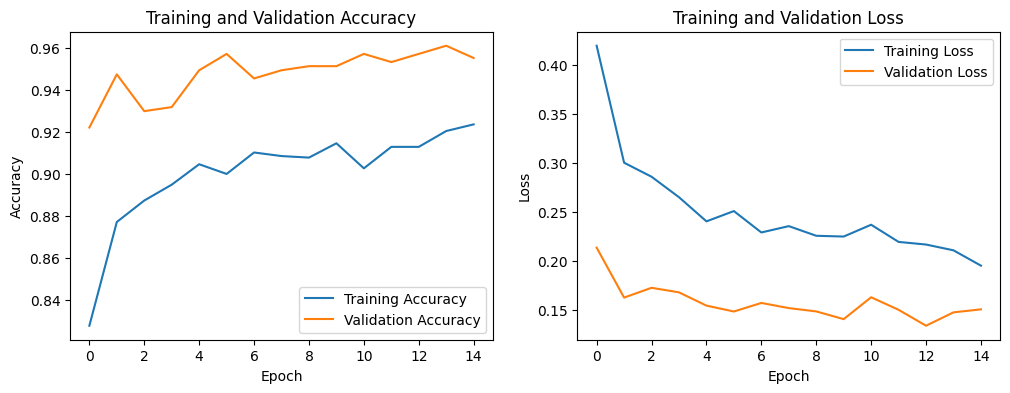


--- Evaluating on Test Data ---
Test Accuracy: 0.9494

Saved prediction examples plot to 'prediction_examples_pytorch.png'


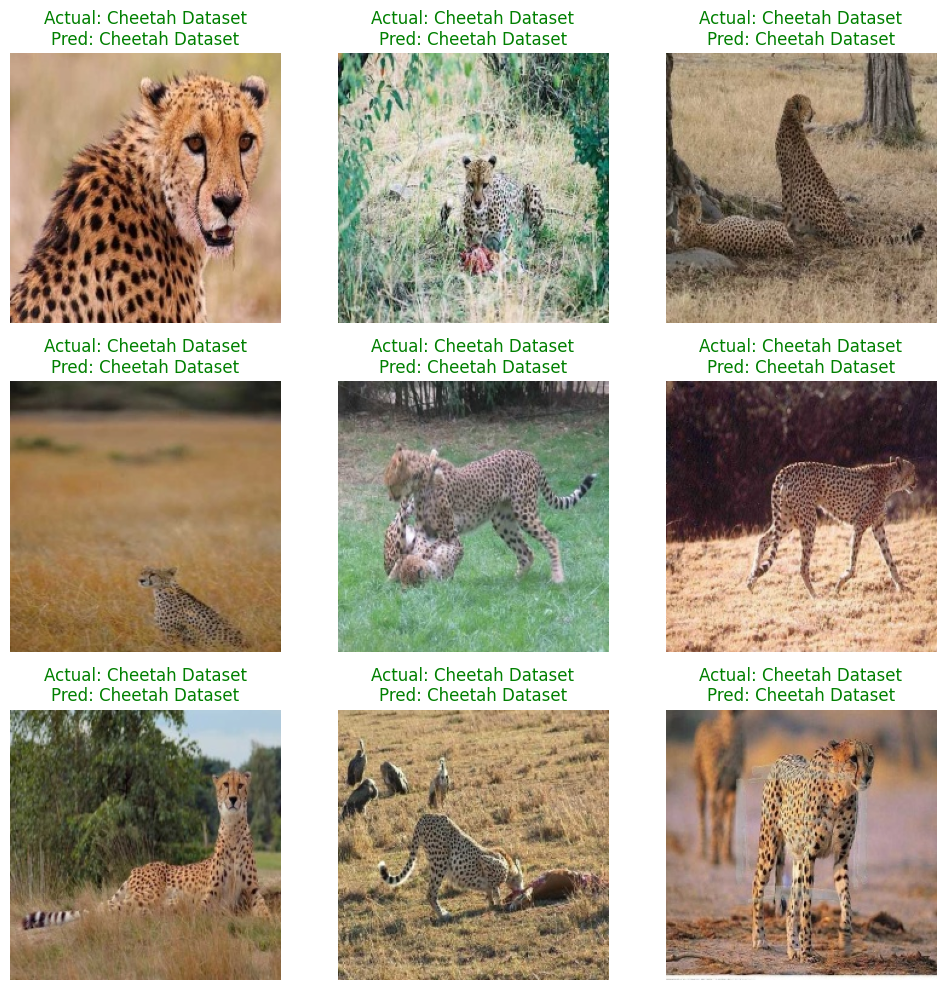


Script finished.


In [1]:
# PyTorch ResNet50 Feature Extraction and Classification

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, transforms, datasets

import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import random
import time

print("### Step 1: Configuration and GPU Check ###")

# --- CONFIGURATION ---
# IMPORTANT: Update these paths.
# SOURCE_DATA_DIR: Path to the original folder with class subdirectories (e.g., 'tiger', 'leopard')
SOURCE_DATA_DIR = '/content/drive/MyDrive/Datasets'

# DATA_DIR: Path where the 'train', 'validation', and 'test' folders will be created.
SPLIT_DATA_DIR = '/content/drive/MyDrive/split_animal_dataset'

IMAGE_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 15
LEARNING_RATE = 0.001
SPLIT_RATIOS = (0.8, 0.1, 0.1) # Train, Validation, Test

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(f"\n✅ GPU ({torch.cuda.get_device_name(0)}) is available and will be used.")
else:
    print("\n⚠️ No GPU found. Training will be on CPU.")

# Mount Google Drive (if in Colab)
try:
    from google.colab import drive
    drive.mount('/content/drive')
    print("Google Drive mounted successfully.")
except ImportError:
    print("Not in a Colab environment. Assuming local file paths.")


print("\n### Step 2: (Optional) Automatically Split the Dataset ###")

def split_data(source_dir, dest_dir, ratios=(0.8, 0.1, 0.1)):
    """Splits data from source directory into train, validation, and test sets."""
    if os.path.exists(dest_dir):
        print(f"'{dest_dir}' already exists. Skipping split process.")
        return
    if not os.path.exists(source_dir):
        print(f"Error: Source directory '{source_dir}' not found. Please check the path.")
        return

    print(f"Creating directory structure at '{dest_dir}'...")
    train_dir = os.path.join(dest_dir, 'train')
    val_dir = os.path.join(dest_dir, 'val')
    test_dir = os.path.join(dest_dir, 'test')
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    for class_name in os.listdir(source_dir):
        class_path = os.path.join(source_dir, class_name)
        if os.path.isdir(class_path):
            print(f"\nProcessing class: {class_name}")
            os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
            os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
            os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

            files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
            random.shuffle(files)

            train_split = int(len(files) * ratios[0])
            val_split = int(len(files) * (ratios[0] + ratios[1]))

            train_files, val_files, test_files = files[:train_split], files[train_split:val_split], files[val_split:]

            def copy_files(file_list, dest_folder):
                for f in file_list:
                    shutil.copy(os.path.join(class_path, f), os.path.join(dest_folder, class_name, f))

            copy_files(train_files, train_dir)
            copy_files(val_files, val_dir)
            copy_files(test_files, test_dir)
    print("\nData splitting complete!")

# Run the splitting function
split_data(SOURCE_DATA_DIR, SPLIT_DATA_DIR, SPLIT_RATIOS)


print("\n### Step 3: Create Data Loaders ###")

# Data transforms with augmentation for training, and normalization for validation/test
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(IMAGE_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(SPLIT_DATA_DIR, x), data_transforms[x]) for x in ['train', 'val', 'test']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=(x=='train'), num_workers=2) for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

print(f"Found classes: {class_names}")
print(f"Dataset sizes: {dataset_sizes}")


print("\n### Step 4: Build the Model ###")

# Load pre-trained ResNet50
resnet_features = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# Freeze all the parameters in the feature extractor
for param in resnet_features.parameters():
    param.requires_grad = False

# Get the number of input features for the classifier
num_ftrs = resnet_features.fc.in_features

# Create a new classifier head
classifier = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, len(class_names))
)

# Replace the original classifier
resnet_features.fc = classifier

# Move the model to the GPU
model = resnet_features.to(device)

print("Model architecture created successfully.")
print(model.fc)

criterion = nn.CrossEntropyLoss()
# Observe that only parameters of the final layer are being optimized
optimizer = optim.Adam(model.fc.parameters(), lr=LEARNING_RATE)


print("\n### Step 5: Train the Model ###")

def train_model(model, criterion, optimizer, num_epochs=10):
    since = time.time()
    best_model_wts = model.state_dict()
    best_acc = 0.0

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model, history

# Start training
model, history = train_model(model, criterion, optimizer, num_epochs=EPOCHS)


print("\n### Step 6: Evaluate and Visualize ###")

def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Training Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.savefig('training_history_pytorch.png')
    print("Saved training history plot to 'training_history_pytorch.png'")
    plt.show()

plot_history(history)

# Evaluate on the test set
def evaluate_test_set(model):
    model.eval()
    running_corrects = 0

    print("\n--- Evaluating on Test Data ---")
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

        running_corrects += torch.sum(preds == labels.data)

    test_acc = running_corrects.double() / dataset_sizes['test']
    print(f'Test Accuracy: {test_acc:.4f}')

evaluate_test_set(model)

# Visualize predictions
def visualize_predictions(model, num_images=9):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(10, 10))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//3, 3, images_so_far)
                ax.axis('off')

                pred_class = class_names[preds[j]]
                actual_class = class_names[labels[j]]
                title_color = 'green' if pred_class == actual_class else 'red'
                ax.set_title(f'Actual: {actual_class}\nPred: {pred_class}', color=title_color)

                # Un-normalize and display image
                inp = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                inp = std * inp + mean
                inp = np.clip(inp, 0, 1)
                plt.imshow(inp)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    plt.tight_layout()
                    plt.savefig('prediction_examples_pytorch.png')
                    print("\nSaved prediction examples plot to 'prediction_examples_pytorch.png'")
                    plt.show()
                    return
        model.train(mode=was_training)

visualize_predictions(model)


### Step 7: Feature Extraction and t-SNE Visualization ###
Extracting features for t-SNE visualization...
Features extracted. Shape: (514, 2048)
Saving feature vectors to CSV file...
Saved feature vectors to 'feature_vectors.csv'
Running t-SNE... (This may take a moment)


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Plotting t-SNE results...
Saved t-SNE plot to 'tsne_visualization_pytorch.png'


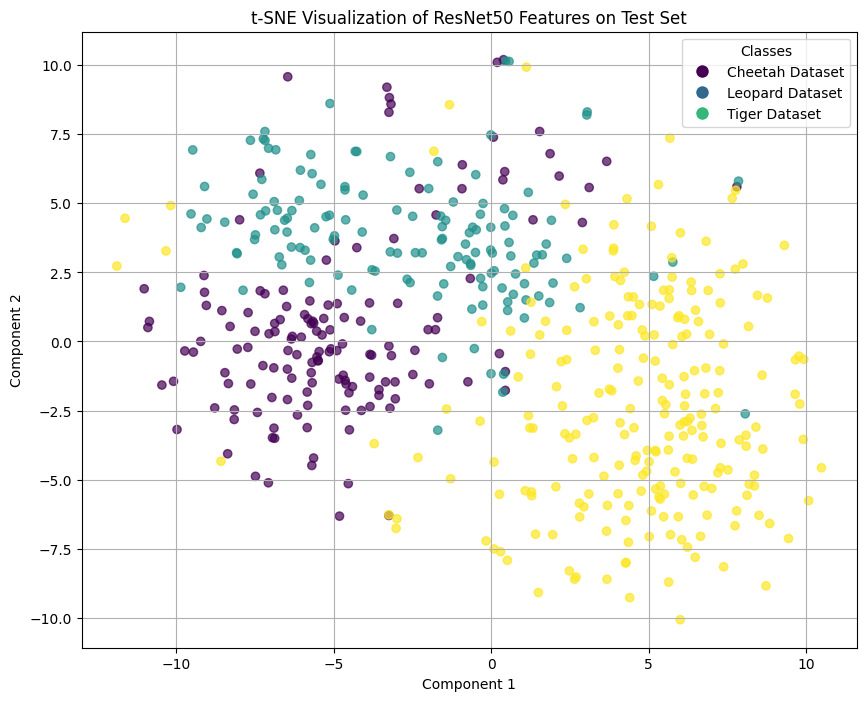

In [5]:
from sklearn.manifold import TSNE
import pandas as pd

print("\n### Step 7: Feature Extraction and t-SNE Visualization ###")

def extract_and_visualize_features(model, dataloader, device, class_names):
    """Extracts features from the layer before the classifier and visualizes them with t-SNE."""
    print("Extracting features for t-SNE visualization...")
    model.eval()

    # Create a new model that outputs the features before the final classifier layer
    feature_extractor = nn.Sequential(*list(model.children())[:-1])
    feature_extractor.to(device)

    all_features = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            features = feature_extractor(inputs)
            # Flatten the features from the avgpool layer
            features = features.view(features.size(0), -1)
            all_features.append(features.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_features = np.concatenate(all_features, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    print(f"Features extracted. Shape: {all_features.shape}")

    # --- Save features to CSV ---
    print("Saving feature vectors to CSV file...")
    # Combine labels and features
    labels_reshaped = all_labels.reshape(-1, 1)
    combined_data = np.hstack([labels_reshaped, all_features])

    # Create column names
    feature_columns = [f'feature_{i+1}' for i in range(all_features.shape[1])]
    columns = ['label'] + feature_columns

    # Create and save DataFrame
    df = pd.DataFrame(combined_data, columns=columns)
    df['label'] = df['label'].astype(int).map({i: class_name for i, class_name in enumerate(class_names)}) # Map labels to class names
    df.to_csv('feature_vectors.csv', index=False)
    print("Saved feature vectors to 'feature_vectors.csv'")

    # Run t-SNE
    print("Running t-SNE... (This may take a moment)")
    tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
    features_2d = tsne.fit_transform(all_features)

    # Plot
    print("Plotting t-SNE results...")
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=all_labels, cmap='viridis', alpha=0.7)

    # Create a legend
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=class_name,
                          markerfacecolor=plt.cm.viridis(i / len(class_names)), markersize=10)
               for i, class_name in enumerate(class_names)]
    plt.legend(handles=handles, title='Classes')

    plt.title("t-SNE Visualization of ResNet50 Features on Test Set")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.grid(True)
    plt.savefig('tsne_visualization_pytorch.png')
    print("Saved t-SNE plot to 'tsne_visualization_pytorch.png'")
    plt.show()

# Use the test dataloader for visualization to see how the model generalizes
extract_and_visualize_features(model, dataloaders['test'], device, class_names)


In [7]:
from sklearn.metrics import classification_report, f1_score, accuracy_score
print("\n### Step 8: Generate Performance Metrics Report ###")

def generate_performance_report(model, dataloader, device, class_names):
    """Generates and prints a detailed performance report for the model on the test set."""
    print("\nGenerating performance report on the test set...")
    model.eval()

    all_labels = torch.tensor([], dtype=torch.long).to(device)
    all_preds = torch.tensor([], dtype=torch.long).to(device)

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_labels = torch.cat((all_labels, labels))
            all_preds = torch.cat((all_preds, preds))

    # Move tensors to CPU and convert to numpy arrays for sklearn
    all_labels_np = all_labels.cpu().numpy()
    all_preds_np = all_preds.cpu().numpy()

    # Calculate metrics
    accuracy = accuracy_score(all_labels_np, all_preds_np)
    f1 = f1_score(all_labels_np, all_preds_np, average='weighted')
    report = classification_report(all_labels_np, all_preds_np, target_names=class_names)

    print(f"\nOverall Accuracy: {accuracy:.4f}")
    print(f"Weighted F1 Score: {f1:.4f}")
    print("\nClassification Report:")
    print(report)

# Call the function using the test dataloader
generate_performance_report(model, dataloaders['test'], device, class_names)



### Step 8: Generate Performance Metrics Report ###

Generating performance report on the test set...

Overall Accuracy: 0.9494
Weighted F1 Score: 0.9494

Classification Report:
                 precision    recall  f1-score   support

Cheetah Dataset       0.90      0.94      0.92       146
Leopard Dataset       0.93      0.89      0.91       140
  Tiger Dataset       1.00      1.00      1.00       228

       accuracy                           0.95       514
      macro avg       0.94      0.94      0.94       514
   weighted avg       0.95      0.95      0.95       514

